# Mineral Indices

__Background:__ [Landsat 8](https://landsat.usgs.gov/landsat-8) data is available from April 2013 onwards. Mineral Indices can be used to aid in geological mapping, and exploit differences in the spectral response of landscape and regolith materials. Care needs to be taken in the interpretation of these indices as the scale of the imagery and sensor characteristics can affect the usefulness of the indices.

__Ratios in this notebook:__

\begin{align}
Iron\ Oxide\ Ratio\ &= \frac{RED}{BLUE} \\
\end{align}

\begin{align}
Ferrous\ Minerals\ Ratio &= \frac{SWIR1}{NIR} \\
\end{align}

\begin{align}
Clay\ NIR/SWIR1\ Ratio &= \frac{NIR}{SWIR1} \\
\end{align}

\begin{align}
Clay\ Minerals\ Ratio &= \frac{SWIR1}{SWIR2} \\
\end{align}

\begin{align}
Ferruginous\ Regolith\ Ratio &= \frac{NIR}{GREEN} \\
\end{align}

Equation (1) Iron Oxide Ratio: 
[(Drury 1987, Harris Geospatial Solutions,Inc. 2018, Segal 1982)](## References)

Equation (2) Ferrous Minerals Ratio:
[(Drury 1987, Harris Geospatial Solutions,Inc. 2018, Segal 1982)](## References)

Equation (3) Clay NIR/SWIR Ratio: Reference not found

Equation (4) Clay Minerals Ratio: 
[(Drury 1987, Harris Geospatial Solutions,Inc. 2018, Wilford and Creasey 2002)](## References)

Equation (5) Ferruginous Regolith Ratio:
[(Wilford and Creasey 2002)](## References)
        

__Before you run this notebook:__ This notebook uses the dea module. You need to run "module load dea" in a terminal window and then launch jupyter notebooks in the same window so that your notebook can 'see' the dea module.

__What does this notebook do?:__ This notebook runs mineral indices on Landsat 8 data. You can then save the data as a png image, netcdf and geotiff.

__Date:__ May 2018

__Authors:__ Leo Lymburner, Bex Dunn

## Import modules from standard libraries, datacube and files
Select 'Trust this notebook' to import these modules.

In [3]:
%pylab notebook

import os
from matplotlib import pyplot as plt
import matplotlib.dates
import rasterio
import xarray as xr

#modules for datacube
import datacube
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube.storage.storage import write_dataset_to_netcdf

# set datacube alias (just a string with what you're doing)
dc = datacube.Datacube(app='dc-Mineral Indices')

# Import external functions from dea-notebooks
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts/'))
import BandIndices, DEAPlotting, DEADataHandling
from FileDialogs import *

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

Populating the interactive namespace from numpy and matplotlib


## Edit this cell to choose your area and temporal range
- Date format is yyyy-mm-dd
- 'ls8' is [Landsat 8 OLI](https://landsat.usgs.gov/what-are-band-designations-landsat-satellites)


In [4]:
#Define temporal range
start_of_epoch = '2013-01-01'
end_of_epoch =  '2013-06-12'

#Use this to manually define an upper left/lower right coords
lat_max = -15.2
lat_min = -15.5
lon_max = 128.3
lon_min = 128.6  

query = {'time': (start_of_epoch, end_of_epoch),
         'x' : (lon_min, lon_max),
         'y' : (lat_max, lat_min),
         'crs' : 'EPSG:4326'} #using WGS 84 here

## Load data from [Digital Earth Australia](http://geoscienceaustralia.github.io/digitalearthau/notebooks/DEA_datasets/GettingStartedWithLandSats5-7-8.html)

In [5]:
#call our retrieved xarray dataset ls8_nbart (because we're using nbart see DEA link in heading above)
ls8_nbart, crs, affine = DEADataHandling.load_nbarx(dc=dc, sensor='ls8',query=query)

Loading ls8_nbart_albers
Loaded ls8_nbart_albers
Generating mask ls8_pq_albers
Masked ls8_nbart_albers with ls8_pq_albers and filtered terrain


In [21]:
ls8_nbart

<xarray.Dataset>
Dimensions:          (time: 3, x: 1336, y: 1355)
Coordinates:
  * time             (time) datetime64[ns] 2013-04-26T01:31:31 ...
  * y                (y) float64 -1.618e+06 -1.618e+06 -1.618e+06 -1.618e+06 ...
  * x                (x) float64 -4.007e+05 -4.007e+05 -4.007e+05 -4.007e+05 ...
Data variables:
    coastal_aerosol  (time, y, x) float64 544.0 581.0 560.0 524.0 520.0 ...
    blue             (time, y, x) float64 508.0 535.0 511.0 481.0 474.0 ...
    green            (time, y, x) float64 708.0 730.0 700.0 652.0 665.0 ...
    red              (time, y, x) float64 919.0 952.0 907.0 862.0 870.0 ...
    nir              (time, y, x) float64 1.279e+03 1.299e+03 1.264e+03 ...
    swir1            (time, y, x) float64 821.0 900.0 891.0 794.0 821.0 ...
    swir2            (time, y, x) float64 373.0 464.0 445.0 367.0 367.0 ...
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00,-400750.00|\n| 0.00,-25.00,-1618400.00|\n| 0.00, ...

## Calculate Mineral Indices
\begin{align}
Iron\ Oxide\ Ratio\ &= \frac{RED}{BLUE} \\
\end{align}

\begin{align}
Ferrous\ Minerals\ Ratio &= \frac{SWIR1}{NIR} \\
\end{align}

\begin{align}
Clay\ NIR/SWIR1\ Ratio &= \frac{NIR}{SWIR1} \\
\end{align}

\begin{align}
Clay\ Minerals\ Ratio &= \frac{SWIR1}{SWIR2} \\
\end{align}

\begin{align}
Ferruginous\ Regolith\ Ratio &= \frac{NIR}{GREEN} \\
\end{align}


In [6]:
iron_oxide_ratio =  BandIndices.geological_indices(ls8_nbart, 'IOR') #Iron Oxide Ratio (RED/BLUE)
ferrous_iron =  BandIndices.geological_indices(ls8_nbart, 'FMR') #Ferrous Minerals Ratio (SWIR1/NIR)
clay_nirswir = ls8_nbart.nir/ls8_nbart.swir1  #Clay NIR/SWIR1 (NIR/SWIR1)
clay_swir1_swir2 = BandIndices.geological_indices(ls8_nbart, 'CMR') #Clay Minerals Ratio (SWIR1/SWIR2)
ferruginous_reg = ls8_nbart.nir/ls8_nbart.green #Ferruginous Regolith Ratio (NIR/GREEN)

The formula we are using for Iron Oxide Ratio is (red / blue)
The formula we are using for Ferrous Minerals Ratio is (swir1 / nir)
The formula we are using for Clay Minerals Ratio is (swir1 / swir2)


## Plot the Iron Oxide Ratio (RED/BLUE)

In [22]:
iron_oxide_ratio

<xarray.DataArray (time: 3, y: 1355, x: 1336)>
array([[[1.809055, 1.779439, ...,      nan,      nan],
        [1.724395, 1.725455, ...,      nan,      nan],
        ...,
        [1.333966, 1.431686, ..., 1.563969, 1.508242],
        [1.363806, 1.423019, ..., 1.5     , 1.526455]],

       [[1.807829, 1.831239, ..., 1.802057, 1.81491 ],
        [1.823105, 1.830909, ..., 1.78628 , 1.790404],
        ...,
        [1.397647, 1.483165, ..., 1.661836, 1.634085],
        [1.322506, 1.472628, ..., 1.692118, 1.650873]],

       [[     nan,      nan, ..., 1.714894, 1.710638],
        [     nan,      nan, ..., 1.683544, 1.705637],
        ...,
        [1.324385, 1.388031, ..., 1.54321 , 1.49359 ],
        [1.283063, 1.423459, ..., 1.563786, 1.52795 ]]])
Coordinates:
  * time     (time) datetime64[ns] 2013-04-26T01:31:31 ...
  * y        (y) float64 -1.618e+06 -1.618e+06 -1.618e+06 -1.618e+06 ...
  * x        (x) float64 -4.007e+05 -4.007e+05 -4.007e+05 -4.007e+05 ...

<IPython.core.display.Javascript object>


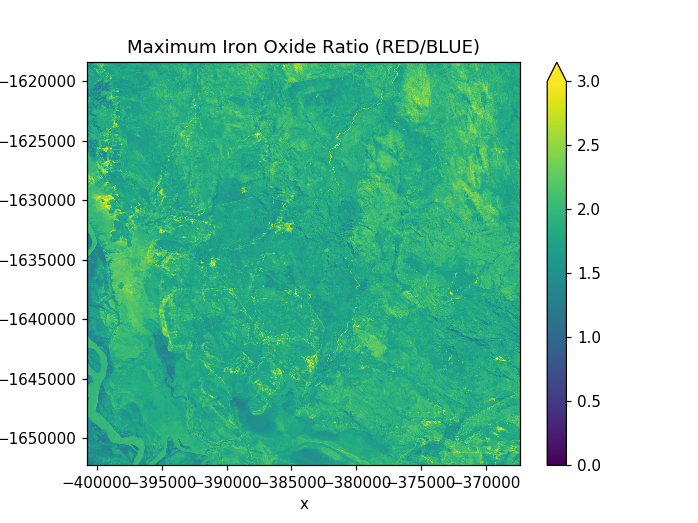

In [23]:
iron_oxide_ratio_stats = iron_oxide_ratio.max(dim = 'time') #you can change .median to .min, .mean, .max
plt.clf()
fig = plt.figure()
iron_oxide_ratio_stats.plot( vmin = 0, vmax = 3)
plt.title('Maximum Iron Oxide Ratio (RED/BLUE)')
plt.show()

## Plot the Ferrous Minerals Ratio (SWIR1/NIR)

<IPython.core.display.Javascript object>


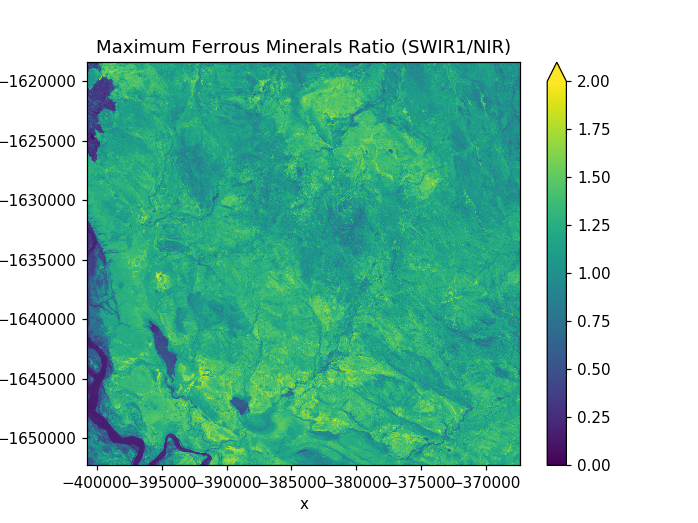

In [8]:
ferrous_iron_stats = ferrous_iron.max(dim = 'time') #you can change .median to .min, .mean, .max
fig = plt.figure()
ferrous_iron_stats.plot(vmin = 0, vmax  = 2)
plt.title('Maximum Ferrous Minerals Ratio (SWIR1/NIR)')
plt.show()

## Plot the Clay NIR/SWIR1 ratio (NIR/SWIR1)

<IPython.core.display.Javascript object>


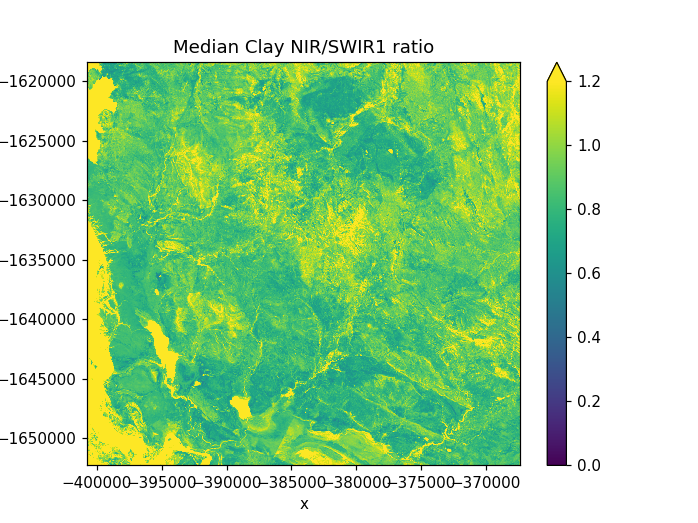

In [9]:
clay_nirswir_stats = clay_nirswir.median(dim = 'time') #you can change .median to .min, .mean, .max
fig = plt.figure()
clay_nirswir_stats.plot(vmin = 0, vmax = 1.2)
plt.title('Median Clay NIR/SWIR1 ratio')
plt.show()

## Plot the Clay Minerals Ratio (SWIR1/SWIR2)

<IPython.core.display.Javascript object>


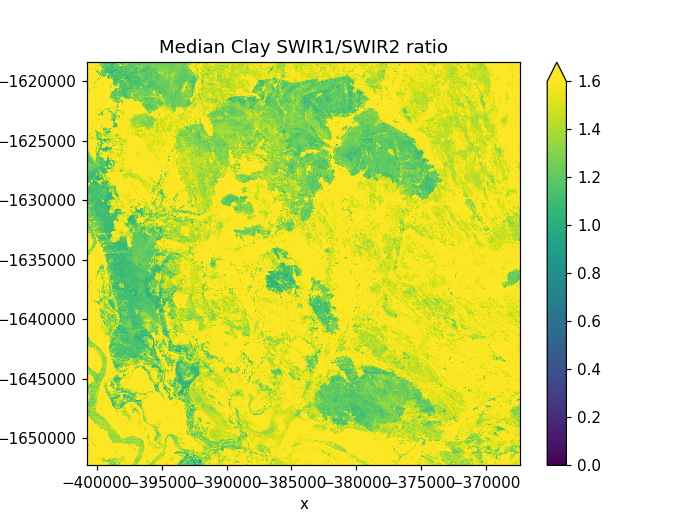

Text(0.5,1,'Median Clay SWIR1/SWIR2 ratio')

In [48]:
clay_swir1_swir2_stats = clay_swir1_swir2.median(dim = 'time') #you can change .median to .min, .mean, .max
fig = plt.figure()
clay_swir1_swir2_stats.plot(vmin = 0, vmax = 1.6)
plt.title('Median Clay SWIR1/SWIR2 ratio')

## Plotting the Ferruginous Regolith Ratio

<IPython.core.display.Javascript object>


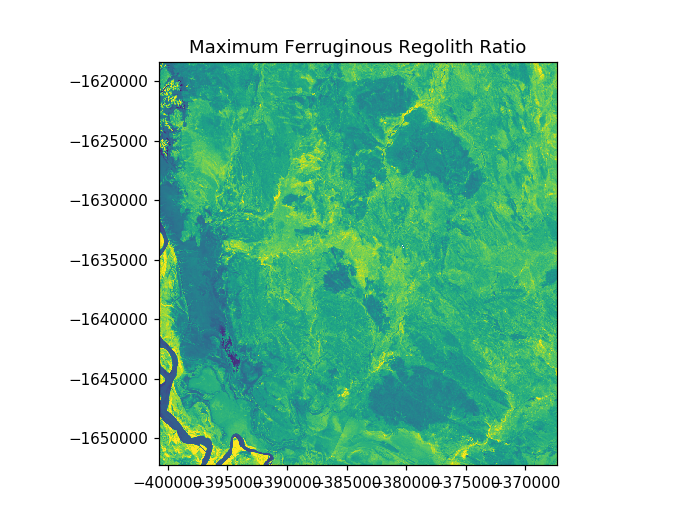

In [10]:
ferruginous_reg_stats = ferruginous_reg.max(dim = 'time') #you can change .median to .min, .mean, .max
fig = plt.figure()
plt.title('Maximum Ferruginous Regolith Ratio')
plt.imshow(ferruginous_reg_stats, vmin = 0, vmax = 5,
           extent=[iron_oxide_ratio_stats.coords['x'].min(), iron_oxide_ratio_stats.coords['x'].max(), 
                   iron_oxide_ratio_stats.coords['y'].min(), iron_oxide_ratio_stats.coords['y'].max()])

## Save ratios to netCDF

In [13]:
#make a list to write the stats to netCDF
stats = [iron_oxide_ratio_stats,ferrous_iron_stats,clay_nirswir_stats,clay_swir1_swir2_stats,ferruginous_reg_stats]
stats_names = ['iron_oxide_ratio_stats','ferrous_iron_stats','clay_nirswir_stats','clay_swir1_swir2_stats','ferruginous_reg_stats']

### Edit save file path to choose where to save your output files

In [52]:
#save files to your home directory (add your outpath here if you want to change it)
savefilepath = os.path.expanduser('~/')

In [16]:
#set up a loop to write each data array to dataset, add the crs to make a proper netcdf, then write our netcdf
for stat in range(len(stats)):
    #turn array into dataset so we can write the netcdf
    dataset = stats[stat].to_dataset(name=stats_names[stat])
    try:
        DEADataHandling.write_your_netcdf(stats[stat], stats_names[stat], savefilepath+stats_names[stat]+'.nc', crs = ls8_nbart.crs)
    #complain if the file already exists but don't fail    
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))
    print('wrote ', stats_names[stat], ' to netCDF' )

wrote  iron_oxide_ratio_stats  to netCDF
wrote  ferrous_iron_stats  to netCDF
wrote  clay_nirswir_stats  to netCDF
wrote  clay_swir1_swir2_stats  to netCDF
wrote  ferruginous_reg_stats  to netCDF


## Save ratios to GeoTiff 


In [51]:
for stat in range(len(stats)):
    try:
        dataset = stats[stat].to_dataset(name=stats_names[stat])
        dataset.attrs['affine']= ls8_nbart.affine
        dataset.attrs['crs']= crs
        write_geotiff(savefilepath+stats_names[stat]+'.tif', dataset)
                #complain if the file already exists but don't fail    
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))
    print('wrote ', stats_names[stat], ' to GeoTiff' )

wrote  iron_oxide_ratio_stats  to GeoTiff
wrote  ferrous_iron_stats  to GeoTiff
wrote  clay_nirswir_stats  to GeoTiff
wrote  clay_swir1_swir2_stats  to GeoTiff
wrote  ferruginous_reg_stats  to GeoTiff


## References

1. Harris Geospatial Solutions,Inc., 2018,*Geology Indices Background*, viewed 23 May 2018, <http://www.harrisgeospatial.com/docs/BackgroundGeologyIndices.html>

2. Drury, S. Image Interpretation in Geology. London: Allen and Unwin (1987), 243 pp.

3. Segal, D., 1982, *Theoretical Basis for Differentiation of Ferric-Iron Bearing Minerals, Using Landsat MSS Data.*,Proceedings of Symposium for Remote Sensing of Environment, 2nd Thematic Conference on Remote Sensing for Exploratory Geology, Fort Worth, TX (1982), pp. 949-951.

4. Wilford, J. W. and Creasey, J., 2002, *Landsat Thematic Mapper*, In Geophysical and Remote Sensing Methods for Regolith Exploration, Edited by: Papp, É. CRCLEME Open File Report 144, pp 6-13.<http://crcleme.org.au/Pubs/OPEN%20FILE%20REPORTS/OFR%20144/03LandsatTM.pdf>
